In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torchvision.transforms.functional import to_pil_image

import os
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from utils.datasets import ImageDataset
from utils.functional import denormalize
from utils.trainers import BasicTrainer

In [2]:
h, w = 256, 256

train_transformer = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

val_test_transformer = transforms.Compose([
    transforms.Resize((h, w)),
    transforms.ToTensor()
])

data\Train\Covid     0
data\Train\Normal     1
228
0


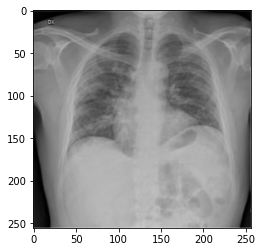

In [3]:
params = {
    "imgs_path": "data\Train",
    "imgs_subfolder": ["Covid", "Normal"],
    "transformer": train_transformer
}

train_ds = ImageDataset(**params)
data = train_ds[0]
img, label = data["x"], data["y"]
img = to_pil_image(img)
print(len(train_ds))
print(label)
plt.imshow(img)

data\Val\Covid     0
data\Val\Normal     1
60
1


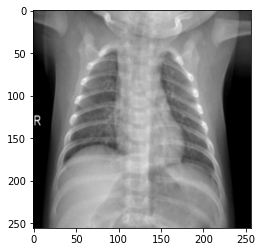

In [4]:
params = {
    "imgs_path": "data\Val",
    "imgs_subfolder": ["Covid", "Normal"],
    "transformer": val_test_transformer
}

val_ds = ImageDataset(**params)
data = val_ds[35]
img, label = data["x"], data["y"]
img = to_pil_image(img)
print(len(val_ds))
print(label)
plt.imshow(img)

data\Test\Covid     0
data\Test\Normal     1
60
0


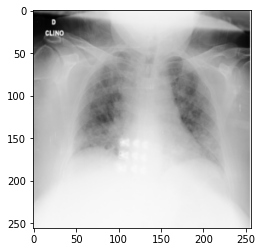

In [5]:
params = {
    "imgs_path": "data\Test",
    "imgs_subfolder": ["Covid", "Normal"],
    "transformer": val_test_transformer
}

test_ds = ImageDataset(**params)
data = test_ds[0]
img, label = data["x"], data["y"]
img = to_pil_image(img)
print(len(test_ds))
print(label)
plt.imshow(img)

In [6]:
batch_size = 1
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [7]:
for data in train_dl:
    xb, yb = data["x"], data['y']
    print(xb.shape, yb.shape, yb[0])
    break

for data in val_dl:
    xb, yb = data["x"], data['y']
    print(xb.shape, yb.shape, yb[0])
    break

for data in test_dl:
    xb, yb = data["x"], data['y']
    print(xb.shape, yb.shape, yb[0])
    break

torch.Size([1, 3, 256, 256]) torch.Size([1]) tensor(1)
torch.Size([1, 3, 256, 256]) torch.Size([1]) tensor(0)
torch.Size([1, 3, 256, 256]) torch.Size([1]) tensor(0)


In [8]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.model = torchvision.models.vgg16(pretrained=True)
        blocks = list(self.model.children())
        for param in self.model.parameters():
            param.requires_grad = False
        # blocks[-1][-1].out_features = 2
        blocks[-1][-1] = nn.Linear(blocks[-1][-1].in_features, 2)
        # list(self.model.children())[2][-1].out_features = 2
    
    def forward(self, x):
        out = self.model(x)

        return out

In [9]:
model = Model()
model

Model(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

In [10]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device, non_blocking=True)
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters())
trainer = BasicTrainer(model, opt, loss_func, None)

In [13]:
params_train = {
    "train_dl": train_dl, 
    "val_dl": val_dl,
    "start_epoch": 1,
    "end_epoch": 25,
    "path_to_weights": "weights.pth",
    "path_to_checkpoint": "checkpoint.pth",
    "device": device,
}

trained_model, loss_history, metric_history = trainer.train_val(**params_train)

Epoch 1/25, current lr=0.001
Training


100%|██████████| 228/228 [00:15<00:00, 14.59it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.18it/s]


Copied best model weights!
train loss: 0.188439, train_accuracy: 89.91, val_loss: 0.047077, val_accuracy: 98.33
Checkpoint saved
----------
Epoch 2/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 16.05it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.13it/s]


Copied best model weights!
train loss: 0.079785, train_accuracy: 96.05, val_loss: 0.038773, val_accuracy: 98.33
Checkpoint saved
----------
Epoch 3/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.44it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.28it/s]


Copied best model weights!
train loss: 0.063815, train_accuracy: 97.81, val_loss: 0.013420, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 4/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.47it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.17it/s]


train loss: 0.050664, train_accuracy: 98.25, val_loss: 0.034847, val_accuracy: 98.33
Checkpoint saved
----------
Epoch 5/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 15.92it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 15.78it/s]


Copied best model weights!
train loss: 0.055049, train_accuracy: 97.37, val_loss: 0.007007, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 6/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 16.28it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.02it/s]


train loss: 0.050626, train_accuracy: 97.37, val_loss: 0.028103, val_accuracy: 98.33
Checkpoint saved
----------
Epoch 7/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 16.13it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.04it/s]


Copied best model weights!
train loss: 0.053430, train_accuracy: 98.25, val_loss: 0.004667, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 8/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.60it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.12it/s]


train loss: 0.035568, train_accuracy: 97.37, val_loss: 0.006511, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 9/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.43it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 15.77it/s]


train loss: 0.037958, train_accuracy: 99.12, val_loss: 0.008602, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 10/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 16.20it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.28it/s]


Copied best model weights!
train loss: 0.058867, train_accuracy: 97.81, val_loss: 0.003941, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 11/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.43it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.27it/s]


Copied best model weights!
train loss: 0.039265, train_accuracy: 98.25, val_loss: 0.001475, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 12/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.58it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.81it/s]


train loss: 0.027650, train_accuracy: 98.25, val_loss: 0.008700, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 13/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.51it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.43it/s]


train loss: 0.026653, train_accuracy: 99.12, val_loss: 0.004145, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 14/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.43it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 15.65it/s]


train loss: 0.020185, train_accuracy: 99.12, val_loss: 0.003553, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 15/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.57it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.49it/s]


Copied best model weights!
train loss: 0.020667, train_accuracy: 99.12, val_loss: 0.000963, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 16/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.66it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.69it/s]


train loss: 0.039598, train_accuracy: 98.68, val_loss: 0.016697, val_accuracy: 98.33
Checkpoint saved
----------
Epoch 17/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.54it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.15it/s]


Copied best model weights!
train loss: 0.039357, train_accuracy: 98.68, val_loss: 0.000700, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 18/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.32it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.49it/s]


train loss: 0.072600, train_accuracy: 98.25, val_loss: 0.031549, val_accuracy: 98.33
Checkpoint saved
----------
Epoch 19/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.53it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.30it/s]


Copied best model weights!
train loss: 0.030555, train_accuracy: 98.68, val_loss: 0.000370, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 20/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.67it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.71it/s]


train loss: 0.003192, train_accuracy: 100.00, val_loss: 0.000528, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 21/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.57it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.24it/s]


train loss: 0.028864, train_accuracy: 98.68, val_loss: 0.000772, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 22/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.38it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 16.52it/s]


train loss: 0.003286, train_accuracy: 100.00, val_loss: 0.000767, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 23/25, current lr=0.001
Training


100%|██████████| 228/228 [00:13<00:00, 16.40it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 15.51it/s]


train loss: 0.010299, train_accuracy: 99.56, val_loss: 0.002755, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 24/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 16.20it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 15.53it/s]


train loss: 0.032368, train_accuracy: 98.68, val_loss: 0.002755, val_accuracy: 100.00
Checkpoint saved
----------
Epoch 25/25, current lr=0.001
Training


100%|██████████| 228/228 [00:14<00:00, 16.07it/s]


Validation


100%|██████████| 60/60 [00:03<00:00, 15.54it/s]


train loss: 0.052019, train_accuracy: 98.25, val_loss: 0.001341, val_accuracy: 100.00
Checkpoint saved
----------


In [15]:
trainer.test(test_dl, device)

100%|██████████| 60/60 [00:03<00:00, 16.11it/s]

loss: 0.147143, accuracy: 96.67


(0.14714272741600093, 0.9666666666666667)

In [19]:
def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

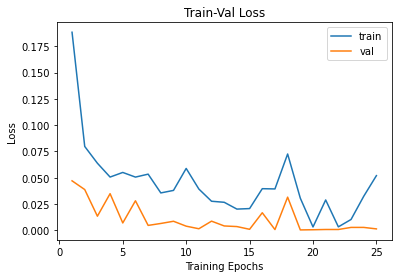

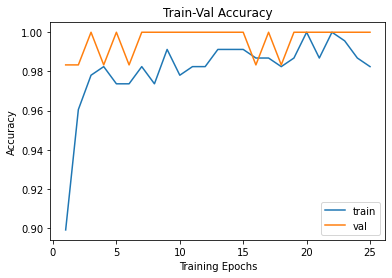

In [20]:
plot_loss(loss_history, metric_history)

In [13]:
weights = torch.load("weights_final.pth")
model = Model()
model.load_state_dict(weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device, non_blocking=True)
loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(model.parameters())
trainer2 = BasicTrainer(model=model, opt=opt, loss_func=loss_func, lr_scheduler=None)

In [16]:
trainer2.test(test_dl, device)

100%|██████████| 60/60 [00:03<00:00, 15.78it/s]

loss: 0.147143, accuracy: 96.67


(0.14714272741600093, 0.9666666666666667)